In [668]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os
import numpy as np
from arch.unitroot import PhillipsPerron
from dotenv import load_dotenv
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VAR
from statsmodels.tsa.stattools import adfuller, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from math import log



load_dotenv()
path_to_data = os.getenv("PATH_TO_DATA") 

def get_data(ticker1, ticker2, path_to_data):
    pair_paths = dict()
    for root, dirs, files in os.walk(path_to_data):
        for name in files:
            if name == f"{ticker1}.csv":
                ticker1_path = str(os.path.join(root, name))
                pair_paths[ticker1] = ticker1_path
            elif name == f"{ticker2}.csv":
                ticker2_path = str(os.path.join(root, name))
                pair_paths[ticker2] = ticker2_path
    return pair_paths

ticker1 = "AZN"
ticker2 = "PFE"

start_time = "2004-06-16"
end_time = "2016-06-16"

pair_paths = get_data(ticker1, ticker2, path_to_data)


with open(rf"{pair_paths[ticker1]}", "r") as s1:
    with open(rf"{pair_paths[ticker2]}", "r") as s2:
        price_df1 = pd.read_csv(s1)
        print(ticker1 + "\n", price_df1)

        price_df2 = pd.read_csv(s2)
        print(ticker2 + "\n", price_df2)

AZN
       Unnamed: 0    datetime   open   high    low  close   volume
0              0  2023-04-19  74.55  74.90  74.41  74.84  4487800
1              1  2023-04-18  75.36  75.83  74.47  75.02  7565700
2              2  2023-04-17  73.76  73.82  73.01  73.63  4408700
3              3  2023-04-14  74.33  74.47  73.57  73.86  3981100
4              4  2023-04-13  74.05  74.83  74.02  74.77  3794200
...          ...         ...    ...    ...    ...    ...      ...
4740        4740  2004-06-21  23.75  23.80  23.63  23.63   841400
4741        4741  2004-06-18  23.79  23.94  23.77  23.77  1615200
4742        4742  2004-06-17  23.64  23.70  23.52  23.68  1135600
4743        4743  2004-06-16  23.75  23.82  23.63  23.77  1060400
4744        4744  2004-06-15  23.43  23.57  23.39  23.48  1637400

[4745 rows x 7 columns]
PFE
       Unnamed: 0    datetime   open   high    low  close    volume
0              0  2023-04-19  40.43  40.56  40.20  40.24  17207800
1              1  2023-04-18  41.28  41

In [669]:
def clean_df(price_df, start_time, end_time):
    price_df = price_df.set_index('datetime')
    price_df.index = pd.to_datetime(price_df.index)
    
    new_price_df = price_df['close'].copy()
    new_price_df = new_price_df.truncate(start_time, end_time)
    
    return new_price_df

price_df1 = clean_df(price_df1, start_time, end_time)
price_df2 = clean_df(price_df2, start_time, end_time)
print(ticker1 + "\n", price_df1)
print(ticker2 + "\n", price_df2)



AZN
 datetime
2016-06-16    27.63
2016-06-15    27.37
2016-06-14    27.26
2016-06-13    27.60
2016-06-10    27.97
              ...  
2004-06-22    23.55
2004-06-21    23.63
2004-06-18    23.77
2004-06-17    23.68
2004-06-16    23.77
Name: close, Length: 3023, dtype: float64
PFE
 datetime
2016-06-16    32.94
2016-06-15    32.98
2016-06-14    33.17
2016-06-13    32.93
2016-06-10    33.45
              ...  
2004-06-22    33.08
2004-06-21    33.37
2004-06-18    33.59
2004-06-17    33.43
2004-06-16    33.39
Name: close, Length: 3023, dtype: float64


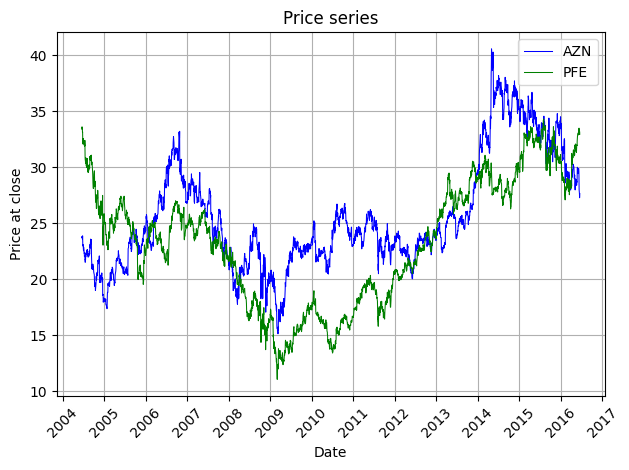

In [670]:
def plot_df(price_df1, price_df2=None, merge_and_plot=False, title="", xlabel="", ylabel="", color="blue"):
    plt.style.use('default')
    
    if merge_and_plot and price_df2 is not None:
        plt.plot(price_df1, color="blue", linewidth=0.75, label=ticker1)
        plt.plot(price_df2, color="green", linewidth=0.75, label=ticker2)
        plt.legend()
    else:
        plt.plot(price_df1, color, linewidth=0.75)
        
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    year_locator = mdates.YearLocator(base=1)
    plt.gca().xaxis.set_major_locator(year_locator)
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_df(price_df1, price_df2, merge_and_plot=True, title="Price series", xlabel="Date", ylabel="Price at close")


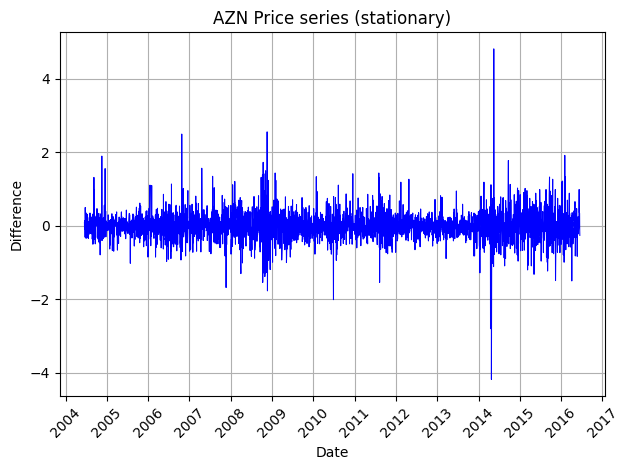

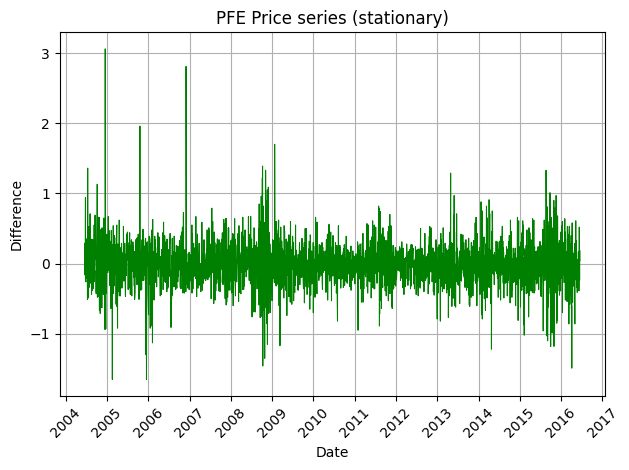

In [671]:
def difference(price_series):
    new_series = price_series - price_series.shift(1)
    new_series = new_series.dropna() 
    new_series.index = price_series.index[1:]
    return new_series

price_df1 = difference(price_df1)
price_df2 = difference(price_df2)

plot_df(price_df1, title=f"{ticker1} Price series (stationary)", xlabel="Date", ylabel="Difference", color="blue")
plot_df(price_df2, title=f"{ticker2} Price series (stationary)", xlabel="Date", ylabel="Difference", color="green")

In [672]:
pp1 = PhillipsPerron(price_df1, trend='n')
print(ticker1 + "...\n", str(pp1.summary()), "\n")

pp2 = PhillipsPerron(price_df2, trend='n')
print(ticker2 + "...\n", str(pp2.summary()))

AZN...
      Phillips-Perron Test (Z-tau)    
Test Statistic                -56.821
P-value                         0.000
Lags                               29
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary. 

PFE...
      Phillips-Perron Test (Z-tau)    
Test Statistic                -55.436
P-value                         0.000
Lags                               29
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [673]:
result = adfuller(price_df1)
result2 = adfuller(price_df2)

print(result[1])
print(result2[1])

1.3795086412207217e-29
9.496993601060815e-19


Fitting an AR Model

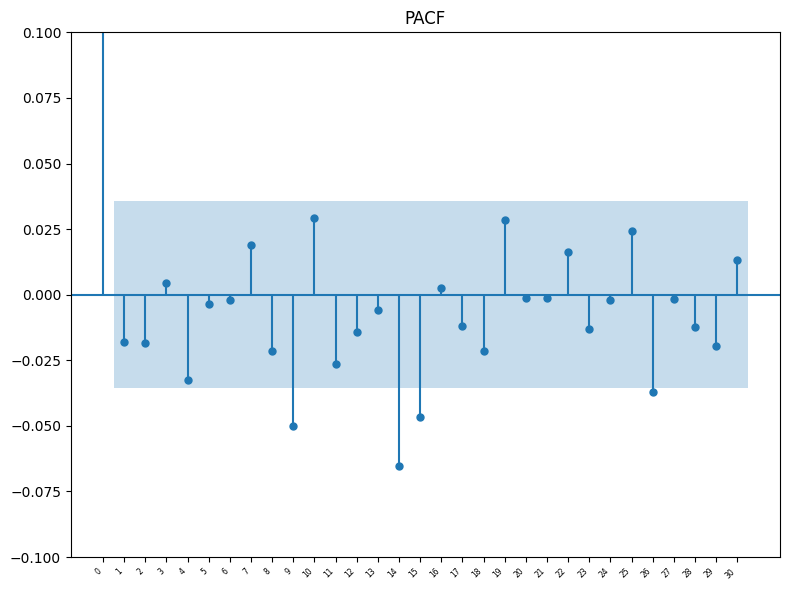

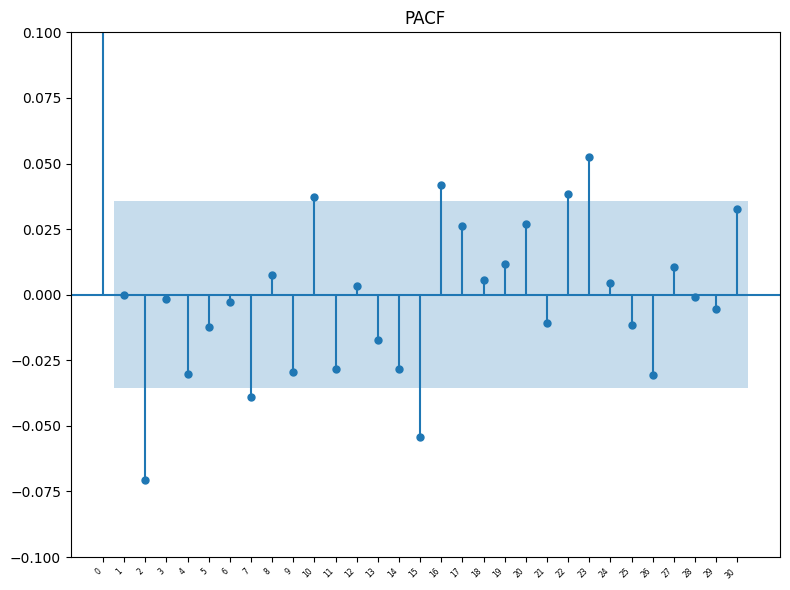

In [674]:
from statsmodels.tsa.stattools import pacf

def plot_and_extract_pacf(price_df, title, lags):
    fig, ax = plt.subplots(figsize=(8, 6))
    y_limit = 0.1
    plot_pacf(price_df, lags=lags, ax=ax)
    ax.set_title(title)
    ax.set_ylim(-y_limit, y_limit)
    tick_positions = np.arange(0, lags + 1)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_positions, rotation=45, ha='right', fontsize=5.5)
    plt.tight_layout()
    plt.show()

lags = 30

result1 = plot_and_extract_pacf(price_df1, title="PACF", lags=lags)
result2 = plot_and_extract_pacf(price_df2, title="PACF", lags=lags)










For price_df1, lag orders 1,9,14,15

For price_df2, lag orders 1,2,15

We'll first look at AR models.

f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

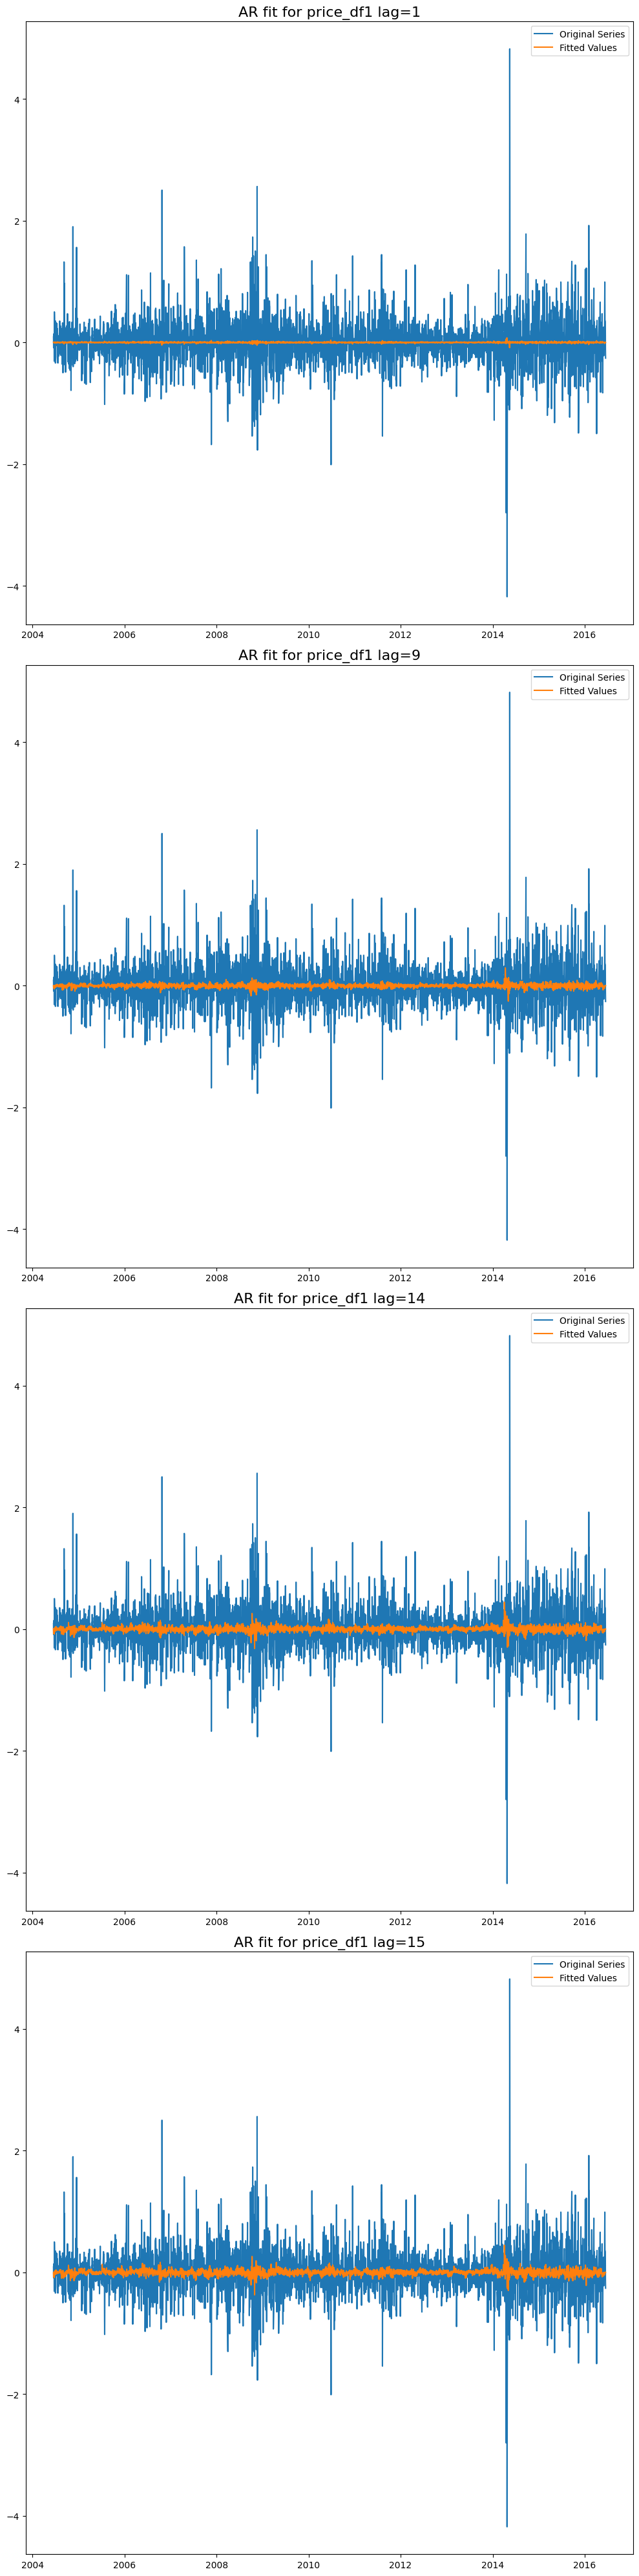

f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self

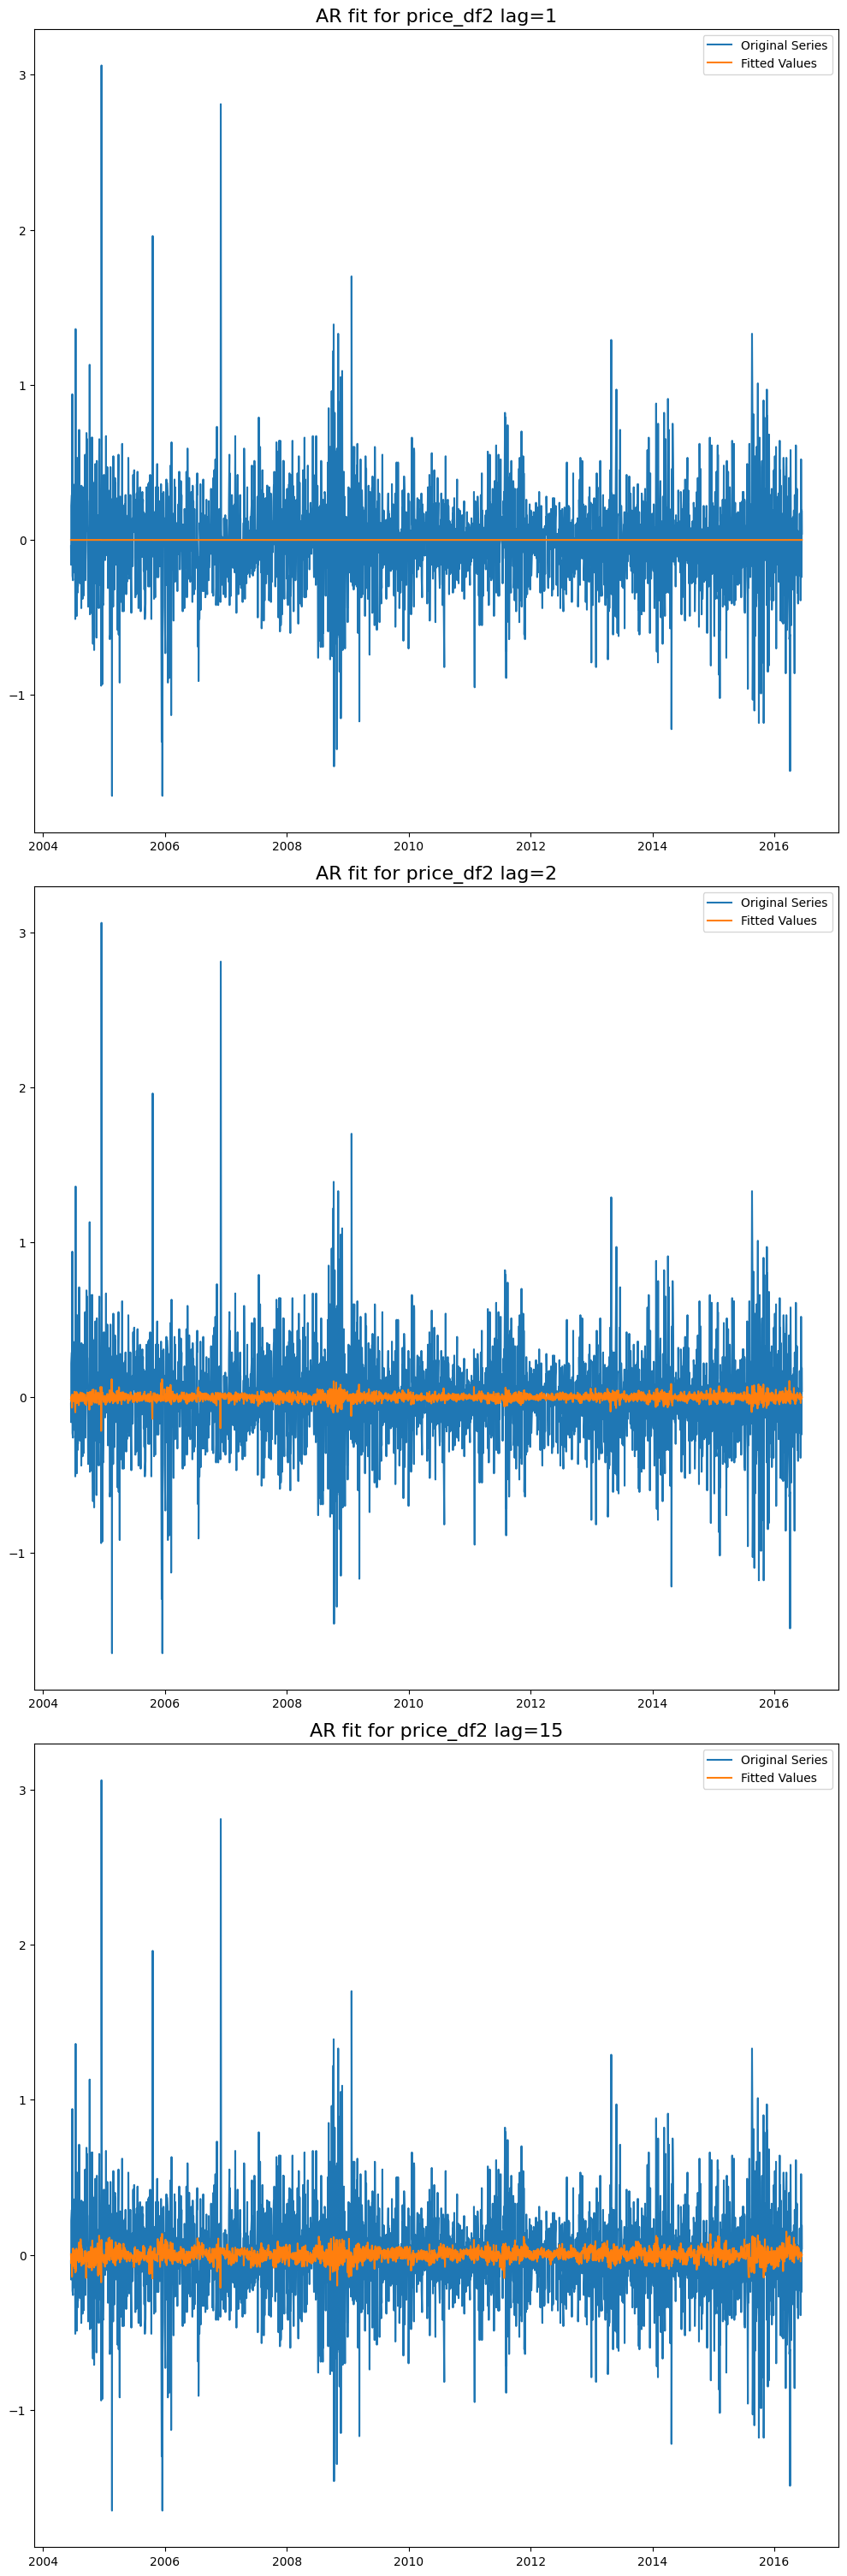

In [675]:
ar_orders1 = [1, 9, 14, 15]
ar_orders2 = [1, 2, 15]
fitted_model1 = dict()
fitted_model2 = dict()

ar_orders1 = [1, 9, 14, 15]
ar_orders2 = [1, 2, 15]
fitted_model1 = dict()
fitted_model2 = dict()


def create_ar_model(ar_orders, series, plot_name="AR model"):
    plt.figure(figsize=(10, 40))
    
    for idx, ar_order in enumerate(ar_orders):
        ar_model = ARIMA(series, order=(ar_order, 0, 0))
        ar_model_fit = ar_model.fit()
        fitted_model1[ar_order] = ar_model_fit
        fitted_values = ar_model_fit.fittedvalues
        
        plt.subplot(4, 1, idx+1)
        plt.plot(series.index, series, label='Original Series')
        plt.plot(series.index, fitted_values, label='Fitted Values')
        plt.title(f'AR fit for {plot_name} lag={ar_order}', fontsize=16)
        plt.legend()
        
    plt.tight_layout()
    plt.show()
    
create_ar_model(ar_orders1, series=price_df1, plot_name="price_df1")
create_ar_model(ar_orders2, series=price_df2, plot_name="price_df2")

In [676]:

# def bayesian_info_crit(price_df1, price_df2, lag_order=range(1,10)):
#     price_df_merged = pd.DataFrame()
#     price_df_merged.index = price_df1.index
#     price_df_merged["Price1"] = price_df1
#     price_df_merged["Price2"] = price_df2
#     bic_values= []
#     var_models = []
#     print(price_df_merged)
#     for lag in lag_order:
#         model = VAR(price_df_merged)
#         results = model.fit(lag)
#         var_models.append(results)
#         if len(price_df1) != len(price_df2):
#             raise Exception("Please ensure that both price series are of the same length")
#         n = len(price_df1)
#         sse = np.sum(np.square(results.resid))  # Sum of squared residuals
#         k = results.df_model
#         bic = n * np.log(sse/n) + k * np.log(n)
#         bic_values.append(bic)
#     return bic_values

# lag_order=range(1,30)
# bic_values = bayesian_info_crit(price_df1, price_df2, lag_order)

# def process_bic_values(bic_values):
#     final_bic_vals = dict()
#     for i, vals in enumerate(bic_values):
#         sum = bic_values[i][0] + bic_values[i][1]
#         final_bic_vals[f"Lag order {i+1}"] = sum
#     return final_bic_vals 


# final_bic_values = process_bic_values(bic_values)
# print(final_bic_values)

# keys =final_bic_values.keys()
# values = final_bic_values.values()
# values = np.log
# plt.bar(keys, values)
# plt.xlabel('Keys')
# plt.ylabel('Values')
# plt.title('Dictionary Plot')
# plt.show()





In [677]:
var_model = VAR(price_df1)
var_results = var_model.fit(lag_order_price_)

f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
f:\Coding\Projects\StatArb\Pairstrading\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ValueError: Only gave one variable to VAR